# Esercizio serie storica

Questo secondo esercizio richiede di effettuare un'analisi di dati di serie storica.

Leggendo il dataset `data/globaltemperatures.csv`, caricare i dati della media della temperatura nei diversi mesi dell'anno dal 1750. Plottare la serie dati, analizarne le caratteristiche (tendenza e stagionalità) e provare a fare una regressione lineare del trend (per valutarne la tendenza). Per fare regressione lineare di una timeseries è conveniente trasformare l'indice (l'asse X) in un numero che indica il numero di periodi passati dal momento inziale.

Infine provare a usare la serie storica per produrre le temperature dei successivi 10 anni.

# Indice
* [Setting](#setting)
* [Lettura dataset](#lettura)
* [Pre processing ed Esplorazione](#esplorazione)
    * [Caratteristiche principali](#)
    * [Verifica duplicati](#)
    * [Verifica missing values](#)
    * [Gestione missing values](#)
    * [Feature engineering](#)
    * [Serie storica a diverse granularità](#)
    * [Analisi distribuzione variabile di interesse](#)
    * [Analisi autocorrelazione](#)
    * [Decomposizione](#)
        * [Analisi tendenza](#)
        * [Analisi stagionalità](#)
        * [Trend e Ciclo](#)
    * [Rolling Mean e Standard Deviation](#)
* [Regressione lineare del trend](#regr)
    * [Preparazione dati](#)
    * [Implementazione modello](#)
    * [Risultati](#)
* [Previsioni con ARIMA](#arima)
    * [Preparazione dati](#)
    * [Verifica stazionarietà](#)
    * [Divisione in train e test](#)
    * [Implementazione modello](#)
    * [Analisi dei residui modello selezionato](#)
    * [Previsioni sul test set](#)
    * [Valutazione perfomances sul test set](#)
    * [Previsioni dal 2016 al 2026](#)
* [Previsioni con Prophet](#prophet)
    * [Preparazione dati](#)
    * [Divisione in train e test](#)
    * [Implementazione modello](#)
    * [Previsioni sul test set](#)
    * [Valutazione perfomances sul test set](#)
    * [Previsioni dal 2016 al 2026](#)

# Setting <a class="anchor" id="setting"></a>

In [9]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import pmdarima as pm

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot

# Lettura dataset <a class="anchor" id="lettura"></a>

In [10]:
df_original = pd.read_csv("data/globaltemperatures.csv")
df = df_original.copy(deep=True)
df.head()


dt  LandAverageTemperature  LandAverageTemperatureUncertainty
0  1750-01-01                   3.034                              3.574
1  1750-02-01                   3.083                              3.702
2  1750-03-01                   5.626                              3.076
3  1750-04-01                   8.490                              2.451
4  1750-05-01                  11.573                              2.072

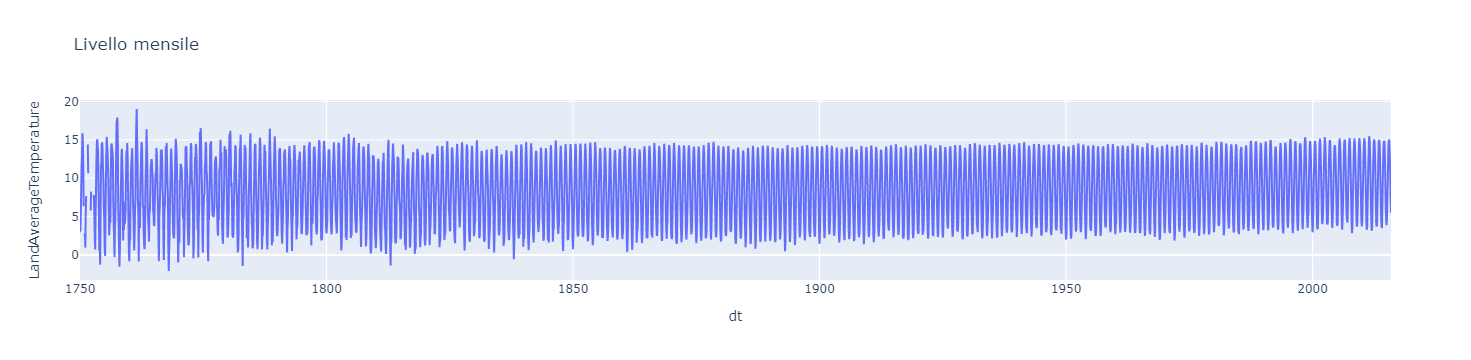

In [11]:
# feature LandAverageTemperature

fig = px.line(df, x=df.dt, y="LandAverageTemperature", title='Livello mensile')
fig.show()

# si osserva un trend leggermente crescente negli ultimi anni in particolare

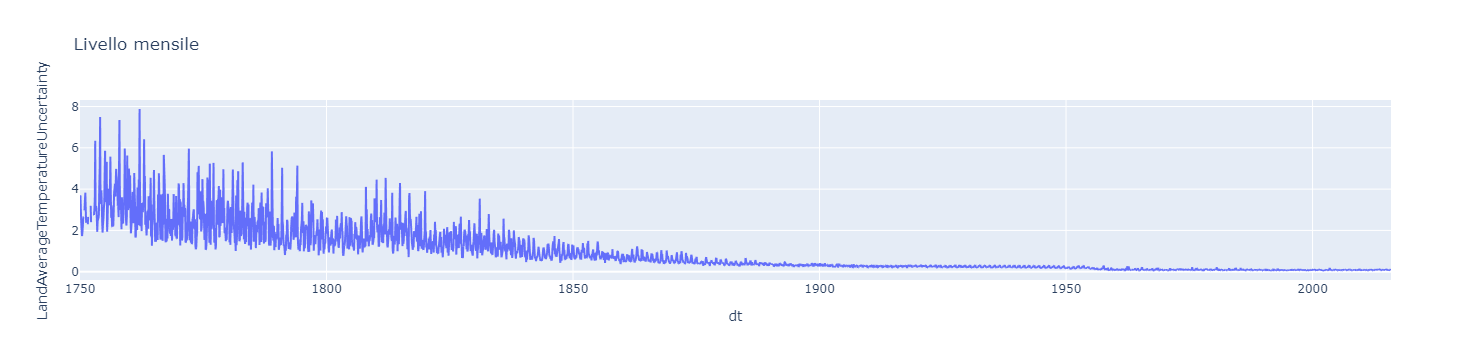

In [12]:
# feature LandAverageTemperatureUncertainty

fig = px.line(df, x=df.dt, y="LandAverageTemperatureUncertainty", title='Livello mensile')
fig.show()

# come prevedibile maggiormente si va nel passato maggiore risulta essere l'incertezza sui valori di LandAverageTemperature

# Pre processing ed Esplorazione <a class="anchor" id="esplorazione"></a>

## Caratteristiche principali

In [13]:
df.shape

(3192, 3)

In [14]:
df.dtypes

dt                                    object
LandAverageTemperature               float64
LandAverageTemperatureUncertainty    float64
dtype: object

In [15]:
df.describe(include='all')

dt  LandAverageTemperature  LandAverageTemperatureUncertainty
count         3192             3180.000000                        3180.000000
unique        3192                     NaN                                NaN
top     1750-01-01                     NaN                                NaN
freq             1                     NaN                                NaN
mean           NaN                8.374731                           0.938468
std            NaN                4.381310                           1.096440
min            NaN               -2.080000                           0.034000
25%            NaN                4.312000                           0.186750
50%            NaN                8.610500                           0.392000
75%            NaN               12.548250                           1.419250
max            NaN               19.021000                           7.880000

## Verifica duplicati

In [16]:
sum(df.duplicated())

# non ci sono duplicati

0

## Verifica missing values

In [17]:
df.isna().sum()

# sono presenti alcuni valori mancanti

dt                                    0
LandAverageTemperature               12
LandAverageTemperatureUncertainty    12
dtype: int64

In [18]:
# vengono analizzati nel dettaglio i valori mancanti

df[df.isna().any(axis=1)]

# dunque i valori mancanti si riferiscono ai primi anni della serie storica

dt  LandAverageTemperature  LandAverageTemperatureUncertainty
10  1750-11-01                     NaN                                NaN
16  1751-05-01                     NaN                                NaN
18  1751-07-01                     NaN                                NaN
21  1751-10-01                     NaN                                NaN
22  1751-11-01                     NaN                                NaN
23  1751-12-01                     NaN                                NaN
25  1752-02-01                     NaN                                NaN
28  1752-05-01                     NaN                                NaN
29  1752-06-01                     NaN                                NaN
30  1752-07-01                     NaN                                NaN
31  1752-08-01                     NaN                                NaN
32  1752-09-01                     NaN                                NaN

## Gestione missing values

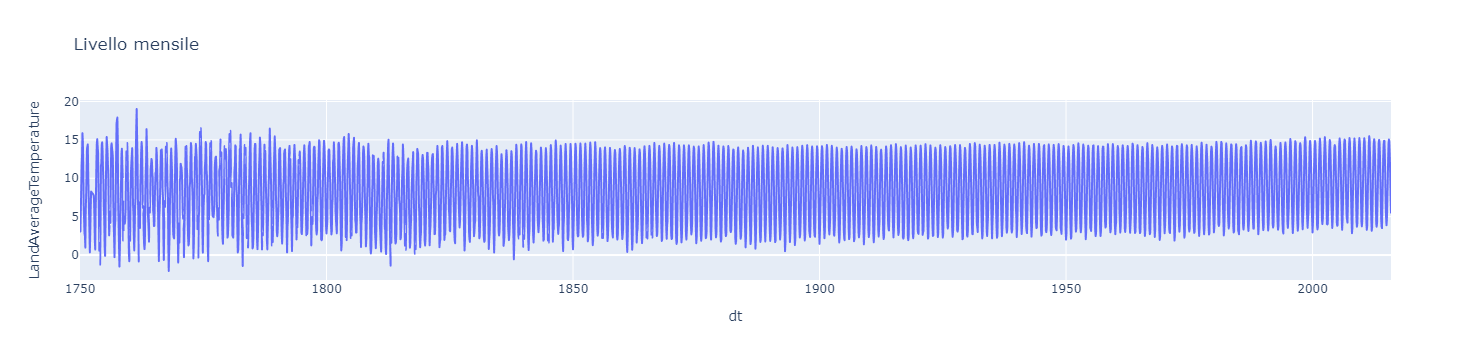

In [19]:
# interpolate: Fill NaN values using an interpolation method
# method ‘time’: Works on daily and higher resolution data to interpolate given length of interval
df = df.interpolate(option='time')

# verifica grafico bontà correzione
fig = px.line(df, x=df.dt, y="LandAverageTemperature", title='Livello mensile')
fig.show()

## Feature engineering

In [20]:
# sistemazione del formato feature data ('dt')

df['dt'] = pd.to_datetime(df['dt'], format='%Y/%m/%d')
df

dt  LandAverageTemperature  LandAverageTemperatureUncertainty
0    1750-01-01                   3.034                              3.574
1    1750-02-01                   3.083                              3.702
2    1750-03-01                   5.626                              3.076
3    1750-04-01                   8.490                              2.451
4    1750-05-01                  11.573                              2.072
...         ...                     ...                                ...
3187 2015-08-01                  14.755                              0.072
3188 2015-09-01                  12.999                              0.079
3189 2015-10-01                  10.801                              0.102
3190 2015-11-01                   7.433                              0.119
3191 2015-12-01                   5.518                              0.100

[3192 rows x 3 columns]

In [21]:
# aggiunta di altre feature potenzialmente utili

df['month'] = df['dt'].dt.month
df['year'] = df['dt'].dt.year
df

dt  LandAverageTemperature  LandAverageTemperatureUncertainty  \
0    1750-01-01                   3.034                              3.574   
1    1750-02-01                   3.083                              3.702   
2    1750-03-01                   5.626                              3.076   
3    1750-04-01                   8.490                              2.451   
4    1750-05-01                  11.573                              2.072   
...         ...                     ...                                ...   
3187 2015-08-01                  14.755                              0.072   
3188 2015-09-01                  12.999                              0.079   
3189 2015-10-01                  10.801                              0.102   
3190 2015-11-01                   7.433                              0.119   
3191 2015-12-01                   5.518                              0.100   

      month  year  
0         1  1750  
1         2  1750  
2         3  1750  
3         4  1750  
4         5  1750  
...     ...   ...  
3187      8  2015  
3188      9  2015  
3189     10  2015  
3190     11  2015  
3191     12  2015  

[3192 rows x 5 columns]

In [22]:
# la feature dt viene impostata come indice del dataframe

df.set_index('dt', inplace=True)

In [23]:
df.head()

LandAverageTemperature  LandAverageTemperatureUncertainty  month  \
dt                                                                             
1750-01-01                   3.034                              3.574      1   
1750-02-01                   3.083                              3.702      2   
1750-03-01                   5.626                              3.076      3   
1750-04-01                   8.490                              2.451      4   
1750-05-01                  11.573                              2.072      5   

            year  
dt                
1750-01-01  1750  
1750-02-01  1750  
1750-03-01  1750  
1750-04-01  1750  
1750-05-01  1750

## Serie storica a diverse granularità

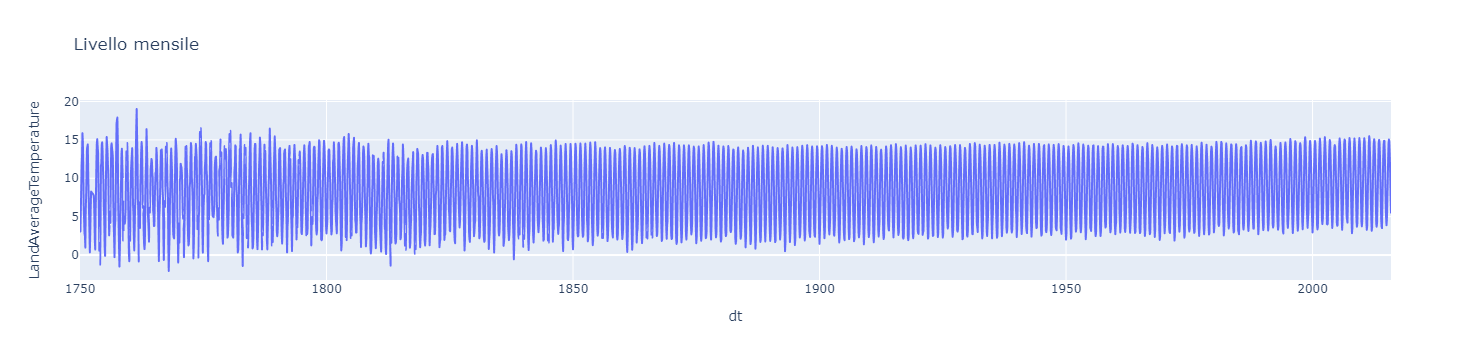

In [24]:
# livello mensile senza missing values

fig = px.line(df, x=df.index, y="LandAverageTemperature", title='Livello mensile')
fig.show()

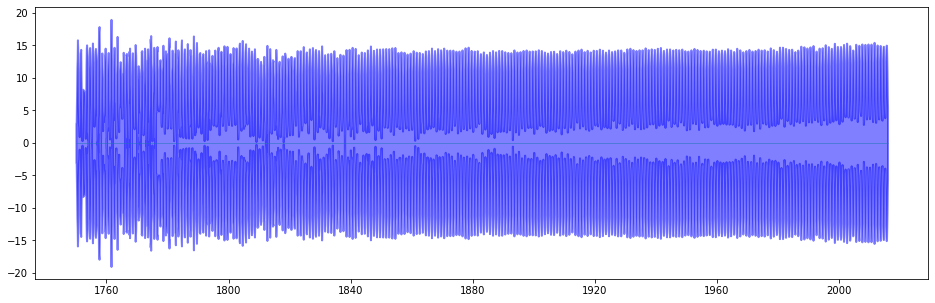

In [25]:
# grafico a specchio a livello mensile

plt.figure(figsize=(16,5))
plt.fill_between(df.index, y1=df['LandAverageTemperature'], y2=-df['LandAverageTemperature'], alpha=0.5, linewidth=2, color='blue')
plt.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=.5)
plt.show()

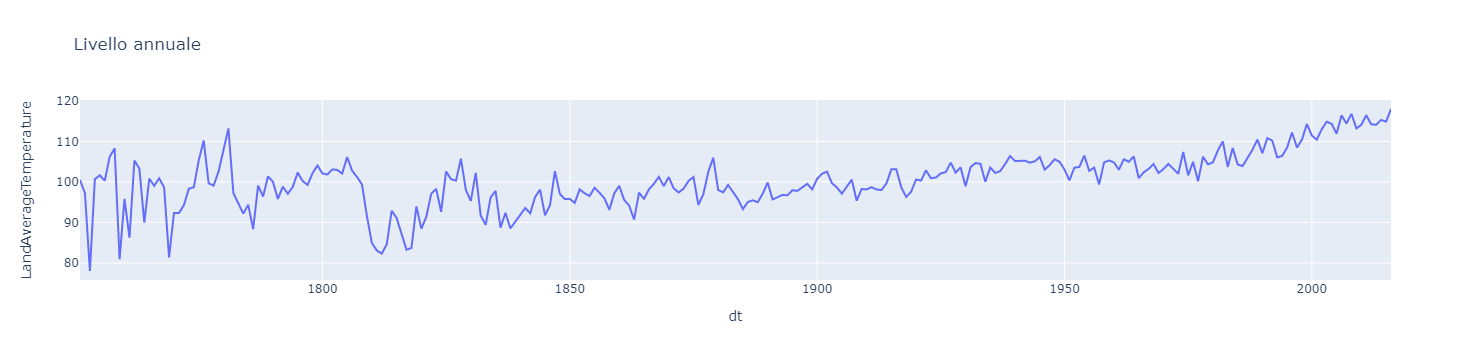

In [26]:
# livello annuale

df_year = df[['LandAverageTemperature']].resample("Y").sum()
fig = px.line(df_year, x=df_year.index, y="LandAverageTemperature", title='Livello annuale')
fig.show()

## Analisi distribuzione variabile di interesse

D:\Anaconda\envs\env_fisica\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



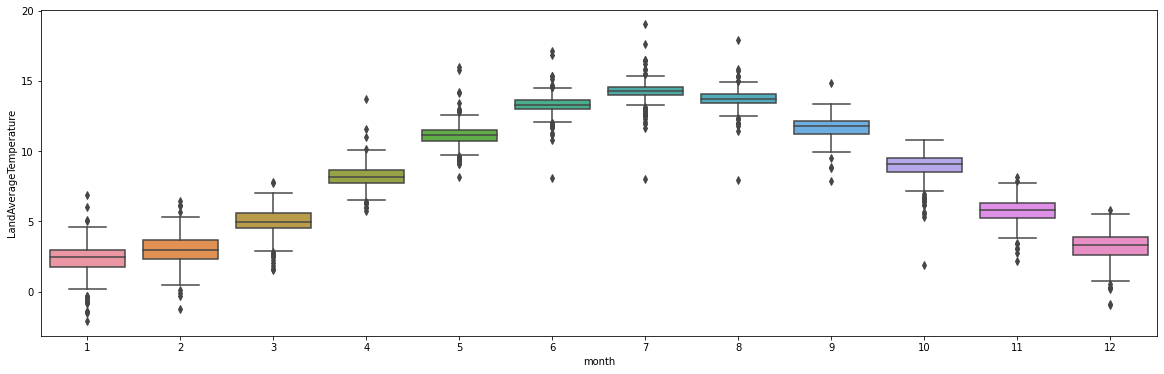

In [27]:
# a livello mensile

fig, ax = plt.subplots(figsize=(20, 6))

sns.boxplot(df['month'], df['LandAverageTemperature'])
ax.set_xlabel('month')
ax.set_ylabel('LandAverageTemperature')

plt.show()

# si nota già qui una stagionalità mensile (ripetizioni di pattern simili ogni 12 osservazioni, ovvero ogni anno), ovvero un aumento delle temperatura terrestre media nei mesi centrali dell'anno

## Analisi autocorrelazione

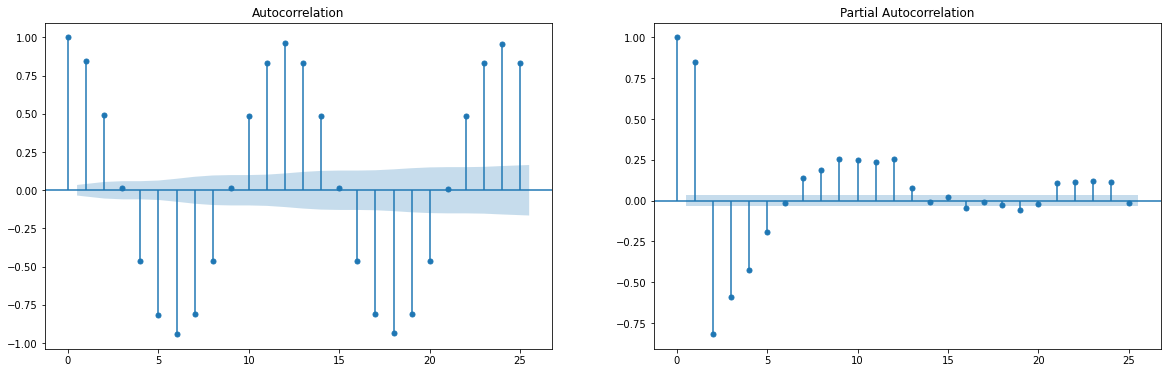

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
plot_acf(df.LandAverageTemperature.tolist(), lags=25, ax=axes[0])
plot_pacf(df.LandAverageTemperature.tolist(), lags=25, ax=axes[1])
plt.show()

# si può notare la presenza di stagionalità come già osservato in precedenza

## Decomposizione

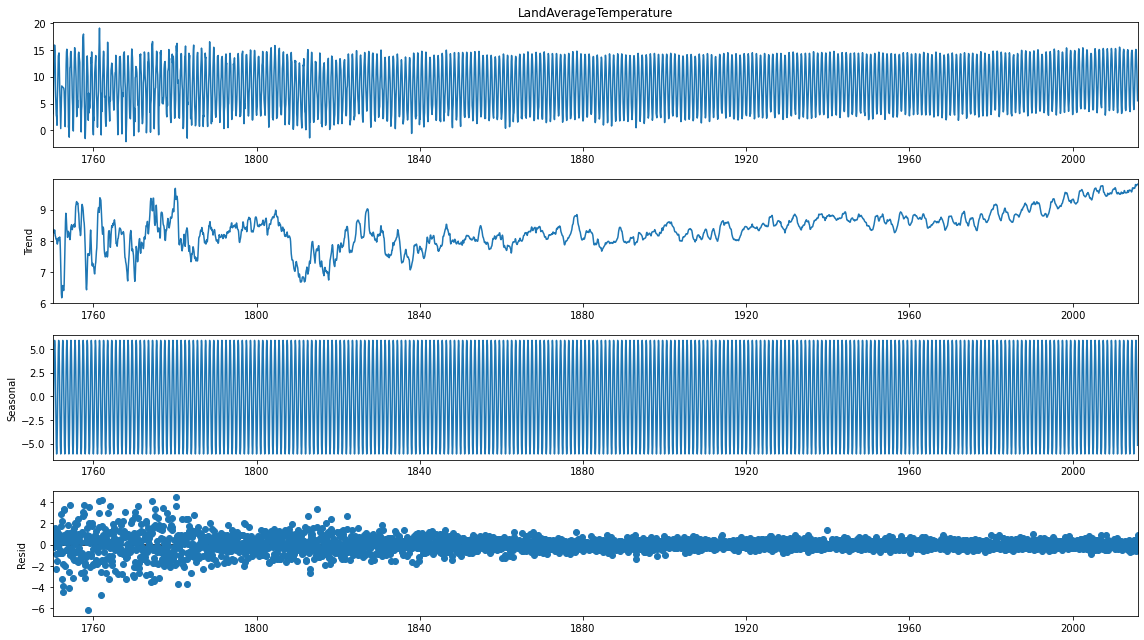

In [29]:
df_test = df.ffill()

# multiplicative Decomposition
result_add = seasonal_decompose(df_test['LandAverageTemperature'], model='additive', extrapolate_trend='freq')

# plot
plt.rcParams.update({'figure.figsize': (16, 9)})
result_add.plot()
plt.show()

### Analisi tendenza

<AxesSubplot:xlabel='dt'>

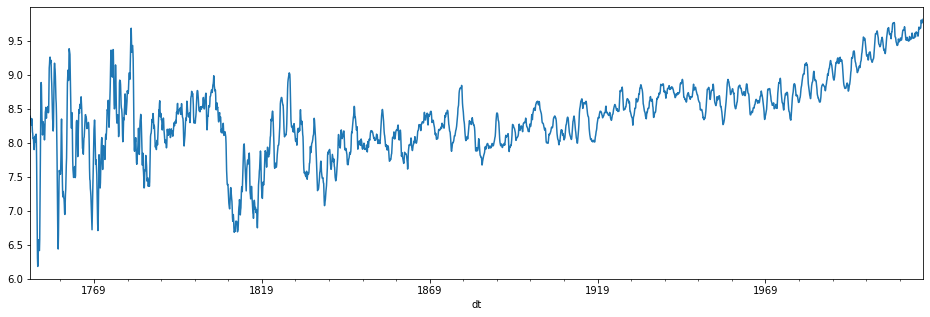

In [30]:
plt.figure(figsize=(16,5))
result_add.trend.plot(legend=False)

# viene rappresentata la pendenza positiva osservata nei dati

# si può osservare un chiaro trend positivo il che indicherebbe che le temperature sono in aumento, in particolar modo negli ultimi anni. Nei primi anni a disposizione si registra una maggiore variabilità

In [31]:
result_add.trend

dt
1750-01-01    8.387605
1750-02-01    8.360928
1750-03-01    8.334252
1750-04-01    8.307576
1750-05-01    8.280900
                ...   
2015-08-01    9.766115
2015-09-01    9.777700
2015-10-01    9.789285
2015-11-01    9.800871
2015-12-01    9.812456
Name: trend, Length: 3192, dtype: float64

### Analisi stagionalità

<AxesSubplot:xlabel='dt'>

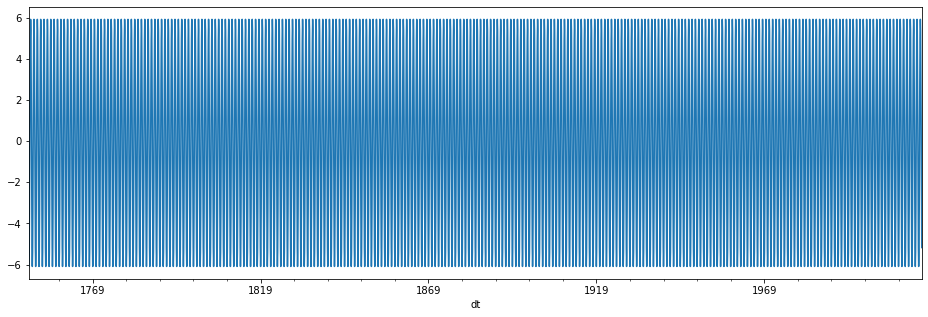

In [32]:
plt.figure(figsize=(16,5))
result_add.seasonal.plot(legend=False)

# si osserva una forte stagionalità che verrà analizzata più nel dettaglio a seguire

In [59]:
result_add.seasonal

dt
1750-01-01   -6.093454
1750-02-01   -5.406483
1750-03-01   -3.411714
1750-04-01   -0.120741
1750-05-01    2.769936
                ...   
2015-08-01    5.365940
2015-09-01    3.335971
2015-10-01    0.508751
2015-11-01   -2.636375
2015-12-01   -5.175941
Name: seasonal, Length: 3192, dtype: float64

<AxesSubplot:xlabel='dt'>

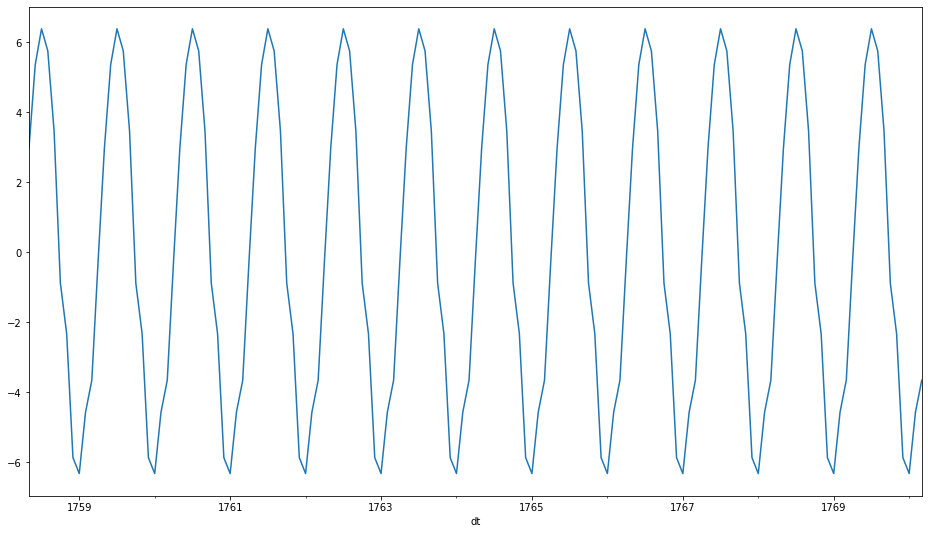

In [63]:
# si analizza più nel dettaglio la stagionalità considerando una finestra temporale ridotta

seasonal_decompose(df_test['LandAverageTemperature'][100:243], model='additive', extrapolate_trend='freq').seasonal.plot(legend=False)

# anche in questo caso si osserva un picco negativo all'inizio dell'anno (temperature basse nei mesi invernali) e un picco positivo (temperature alte nei mesi estivi). Questo pattern si ripete nel corso degli anni

### Trend e Ciclo

C:\Users\loren\AppData\Local\Temp\ipykernel_16536\1728372641.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\loren\AppData\Local\Temp\ipykernel_16536\1728372641.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



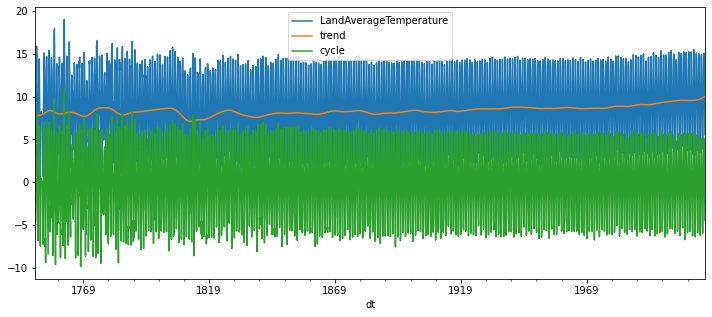

In [61]:
cycle, trend = sm.tsa.filters.hpfilter(df.LandAverageTemperature, 129600)
decomp = df[['LandAverageTemperature']]
decomp["cycle"] = cycle
decomp["trend"] = trend

fig, ax = plt.subplots()
decomp[["LandAverageTemperature", "trend", "cycle"]].plot(ax=ax, figsize=(12, 5))
plt.show()

## Rolling Mean e Standard Deviation

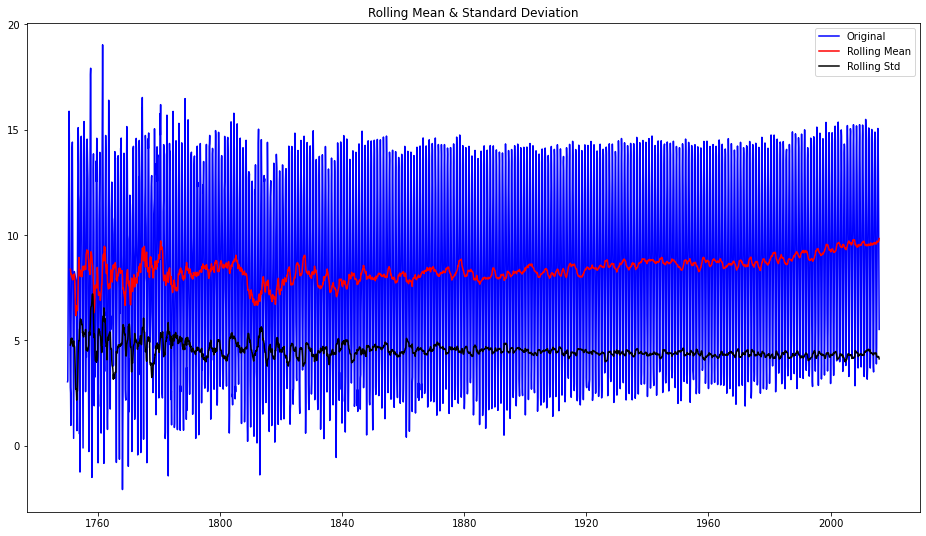

In [58]:
rolmean = df[['LandAverageTemperature']].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = df[['LandAverageTemperature']].rolling(window=12).std()

#Plot rolling statistics
orig = plt.plot(df[['LandAverageTemperature']], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# per soddisfare la condizione di stazionarietà della serie è bene che la rolling mean e la rolling standard deviation rimangano invarianti/costanti nel tempo. Dunque le due curve dovrebbero essere parallele
# all'asse x e in questo caso tale condizione è in parte soddisfatta

# Regressione lineare del trend <a class="anchor" id="regr"></a>

## Preparazione dati

In [76]:
trend_df = pd.DataFrame()
trend_df['y'] = result_add.trend
trend_df = trend_df.reset_index()
trend_df['x'] = list(range(1,3193,1))
trend_df = trend_df[['x', 'y']]
trend_df

## Implementazione modello

In [78]:
model = LinearRegression()

In [79]:
x = trend_df['x'].values
y = trend_df['y'].values

In [80]:
x = x.reshape(3192, 1)
y = y.reshape(3192, 1)

In [81]:
model  = model.fit(x, y)

## Risultati

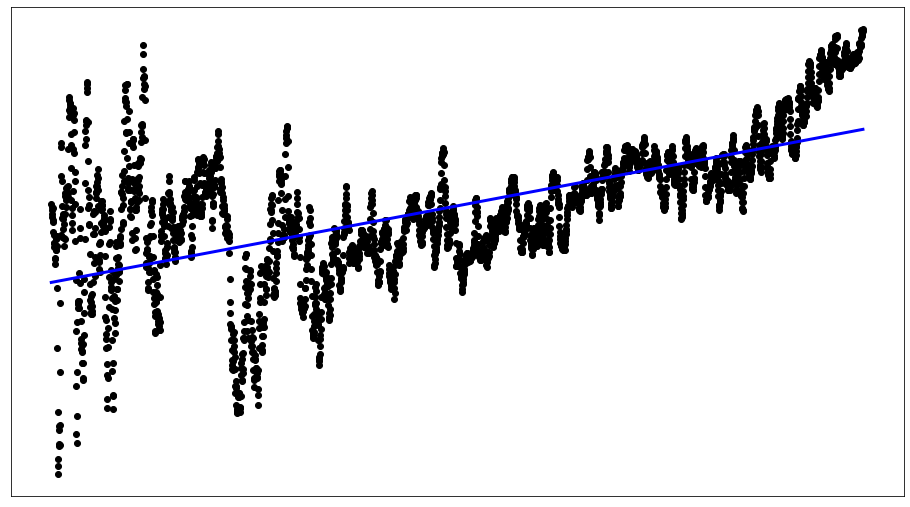

In [82]:
plt.scatter(x, y,  color='black')
plt.plot(x, model.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

# come osservato in precedenza la tendenza del trend è positiva, in crescita

# Previsioni con ARIMA <a class="anchor" id="arima"></a>

Si procede con la previsione dei valori di temperatura per i prossimi 10 anni.

## Preparazione dati

In [83]:
df_arima = df[['LandAverageTemperature']]
df_arima

LandAverageTemperature
dt                                
1750-01-01                   3.034
1750-02-01                   3.083
1750-03-01                   5.626
1750-04-01                   8.490
1750-05-01                  11.573
...                            ...
2015-08-01                  14.755
2015-09-01                  12.999
2015-10-01                  10.801
2015-11-01                   7.433
2015-12-01                   5.518

[3192 rows x 1 columns]

## Verifica stazionarietà

In [84]:
result = adfuller(df_arima.LandAverageTemperature)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# il test sembra indicare che la serie sia stazionaria

ADF Statistic: -4.036404
p-value: 0.001231
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [85]:
# per completezza si prova ad eliminare trend e stagionalità

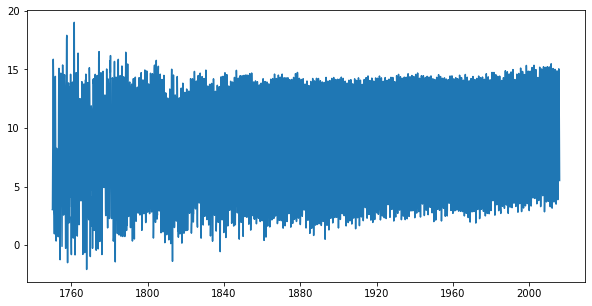

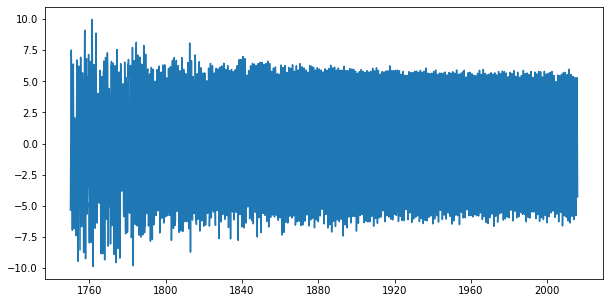

In [86]:
# viene rimosso il trend

plt.rcParams.update({'figure.figsize': (10, 5)})

df_detrend = df_arima.copy()
plt.plot(df_detrend.index, df_detrend.LandAverageTemperature)
plt.show()

result_mul = seasonal_decompose(df_detrend['LandAverageTemperature'], model='additive', extrapolate_trend='freq')
detrended = df_detrend.LandAverageTemperature.values - result_mul.trend

plt.plot(df_detrend.index, detrended)
plt.show()

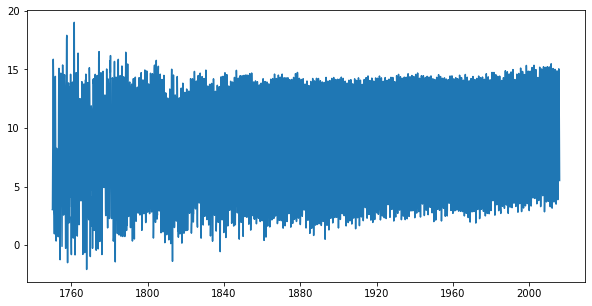

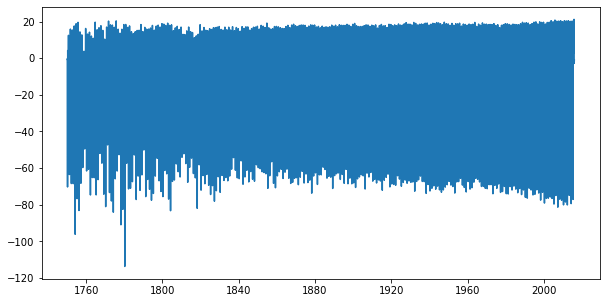

In [87]:
# viene rimossa la stagionalità

plt.rcParams.update({'figure.figsize': (10, 5)})

df_deseason = df_arima.copy()
plt.plot(df_deseason.index, df_deseason.LandAverageTemperature)
plt.show()

result_mul = seasonal_decompose(df_deseason['LandAverageTemperature'], model='additive', extrapolate_trend='freq')
deseasonalized = df_deseason.LandAverageTemperature.values / result_mul.seasonal

plt.plot(df_deseason.index, deseasonalized)
plt.show()

In [88]:
# si procede tuttavia supponendo che i dati siano stazionari

## Divisione in train e test

In [89]:
df_train = df_arima[df_arima.index < '2005-02-01'].copy()['LandAverageTemperature']

df_test = df_arima[df_arima.index >= '2005-02-01'].copy()['LandAverageTemperature']

# check sample size
print('Train: ', df_train.size)
print('Test: ', df_test.size)

Train:  3061
Test:  131


## Implementazione modello

In [ ]:
# il metodo auto_arima permette di determinare automaticamente la migliore combinazione dei valori p, q e d necessari alla costruzione del modello

smodel = pm.auto_arima(df_arima, start_p=1, start_q=1,
                       test='adf',
                       max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

smodel.summary()

In [90]:
# il modello migliore ottenuto risulta essere:
# ARIMA(order=(3, 0, 2), scoring_args={}, seasonal_order=(2, 1, 0, 12), suppress_warnings=True, with_intercept=False)

model_arima = ARIMA(df_train,
             order=(3, 0, 2),
             seasonal_order=(2, 1, 0, 12))
model_arima = model_arima.fit()

D:\Anaconda\envs\env_fisica\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

D:\Anaconda\envs\env_fisica\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

D:\Anaconda\envs\env_fisica\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



## Analisi dei residui modello selezionato

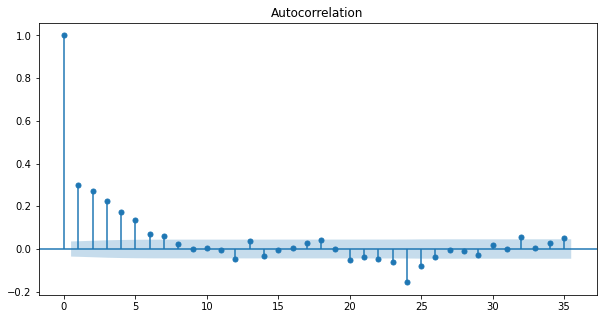

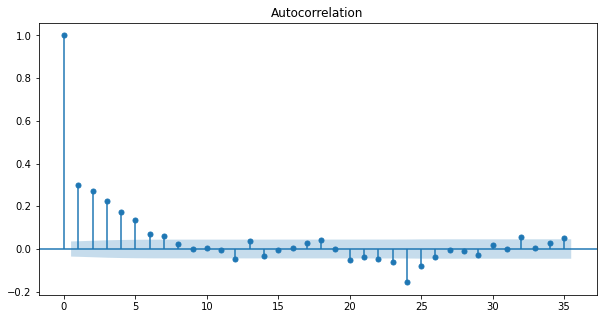

In [91]:
# analisi acf e pacf dei redsidui del modello migliore

plot_acf(model_arima.resid)

## Previsioni sul test set

In [92]:
# previsioni sul test set

pred = model_arima.get_prediction(start=df_test.index[0], end=df_test.index[-1]).predicted_mean
pred

D:\Anaconda\envs\env_fisica\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



2005-02-01     4.385457
2005-03-01     6.306328
2005-04-01     9.181811
2005-05-01    11.943538
2005-06-01    14.005319
                ...    
2015-08-01    14.408232
2015-09-01    12.770561
2015-10-01    10.195165
2015-11-01     7.060713
2015-12-01     4.502828
Freq: MS, Name: predicted_mean, Length: 131, dtype: float64

## Valutazione performances sul test set

C:\Users\loren\AppData\Local\Temp\ipykernel_2684\1530992414.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



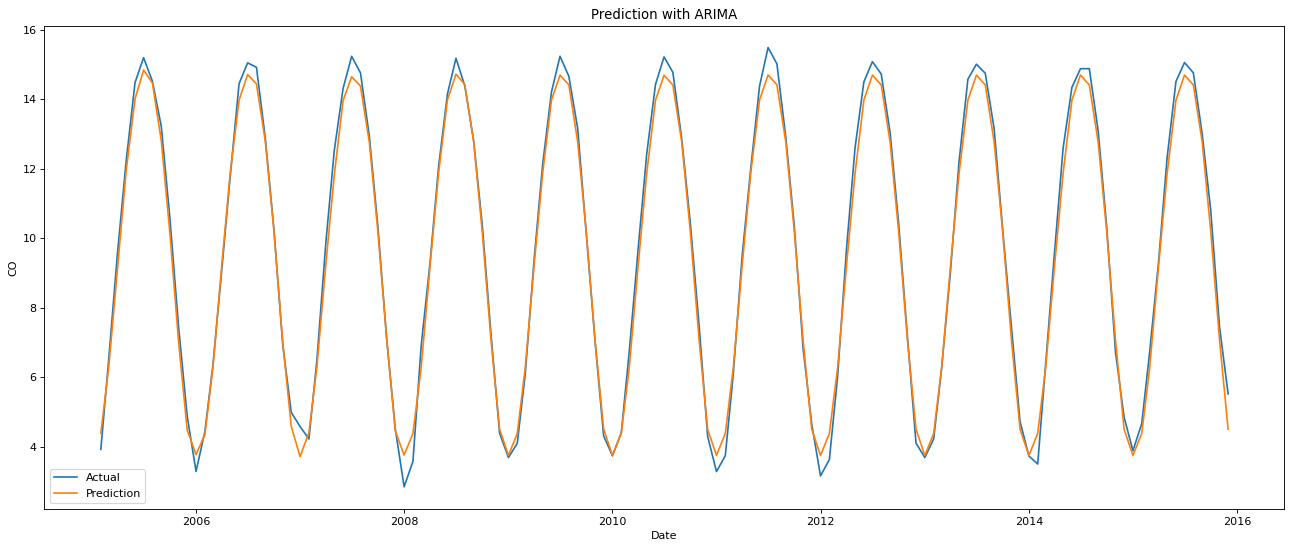

In [93]:
fig=plt.figure(figsize=(20,8), dpi=80)
fig.show()
ax=fig.add_subplot()
plt.title('Prediction with ARIMA')
plt.xlabel('Date')
plt.ylabel('CO')
ax.plot(df_test, label='Actual')
ax.plot(pred, label='Prediction')
plt.legend()
plt.show()

In [94]:
# performances sul test set

aic = model_arima.aic
mape = mean_absolute_percentage_error(df_test, pred)
print('AIC: ', int(aic))
print('MAPE:', round(mape, 4))

AIC:  7902
MAPE: 0.0441


## Previsioni dal 2016 al 2026

In [95]:
dates_future = pd.date_range(start='2016-01-01', end='2026-01-01', freq='M')
df_future = pd.DataFrame()
df_future.index = dates_future
df_future['LandAverageTemperature'] = None
df_future

LandAverageTemperature
2016-01-31                   None
2016-02-29                   None
2016-03-31                   None
2016-04-30                   None
2016-05-31                   None
...                           ...
2025-08-31                   None
2025-09-30                   None
2025-10-31                   None
2025-11-30                   None
2025-12-31                   None

[120 rows x 1 columns]

In [96]:
# previsioni dal 2016 al 2026

pred = model_arima.get_prediction(start=df_future.index[0], end=df_future.index[-1]).predicted_mean
pred

D:\Anaconda\envs\env_fisica\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



2016-02-01     4.381133
2016-03-01     6.275381
2016-04-01     9.199070
2016-05-01    11.853855
2016-06-01    13.968382
                ...    
2025-09-01    12.770596
2025-10-01    10.195111
2025-11-01     7.060663
2025-12-01     4.502734
2026-01-01     3.745296
Freq: MS, Name: predicted_mean, Length: 120, dtype: float64

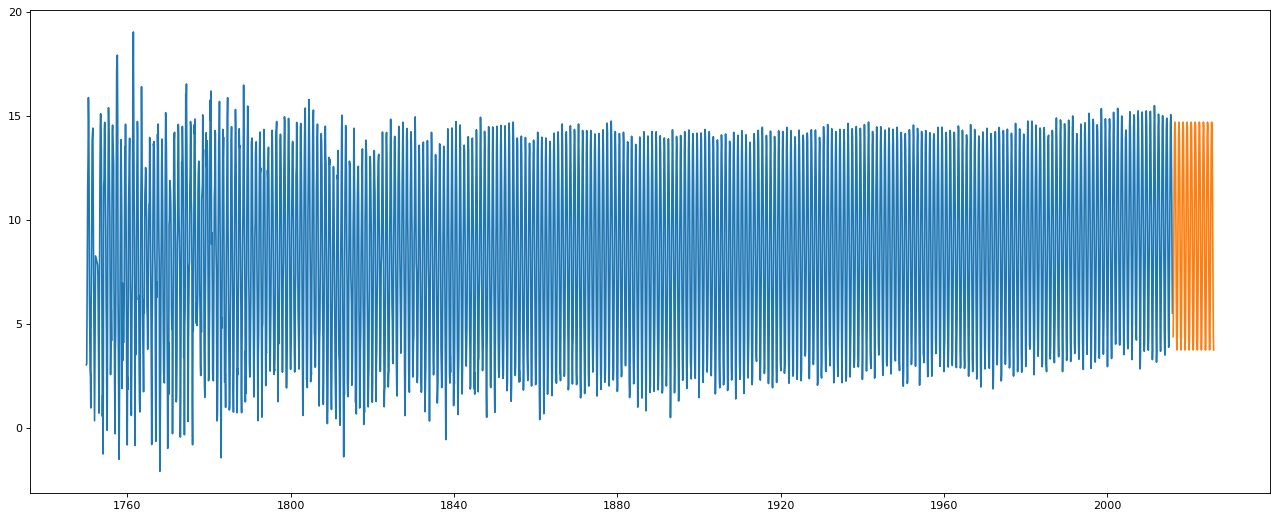

In [97]:
plt.figure(figsize=(20, 8), dpi=80)
plt.plot(df_arima['LandAverageTemperature'])
plt.plot(pred)
plt.show()

# Previsioni con Prophet <a class="anchor" id="prophet"></a>

Prophet è una tecnica per eseguire il task di predizione di serie storiche basato su modello di tipo addittivo dove i trend non lineari sono fittati con stagionalità di diversi tipi, considerando anche gli effetti delle vacanze. Il modello Prophet lavora molto bene con dati che presentano forti effetti stagionali sui dati storici. Prophet inoltre è robusto ai missing values e gestisce molto bene gli outliers (https://facebook.github.io/prophet/).

Tuttavia recentemente ci sono stati alcuni articoli scientifici che hanno messo in dubbio le reali performance di Prophet (https://analyticsindiamag.com/facebook-prophets-existential-crisis/).

Si procede con la previsione dei valori di temperatura per i prossimi 10 anni.

## Preparazione dati

In [98]:
df_prophet = df_arima.copy(deep=True)
df_prophet

# con Prophet non è necessario rendere stazionaria la serie

LandAverageTemperature
dt                                
1750-01-01                   3.034
1750-02-01                   3.083
1750-03-01                   5.626
1750-04-01                   8.490
1750-05-01                  11.573
...                            ...
2015-08-01                  14.755
2015-09-01                  12.999
2015-10-01                  10.801
2015-11-01                   7.433
2015-12-01                   5.518

[3192 rows x 1 columns]

In [99]:
df_prophet = df_prophet.reset_index()
df_prophet

dt  LandAverageTemperature
0    1750-01-01                   3.034
1    1750-02-01                   3.083
2    1750-03-01                   5.626
3    1750-04-01                   8.490
4    1750-05-01                  11.573
...         ...                     ...
3187 2015-08-01                  14.755
3188 2015-09-01                  12.999
3189 2015-10-01                  10.801
3190 2015-11-01                   7.433
3191 2015-12-01                   5.518

[3192 rows x 2 columns]

In [100]:
df_prophet = df_prophet.rename(columns = {'dt': 'ds', 'LandAverageTemperature':'y'})
df_prophet

ds       y
0    1750-01-01   3.034
1    1750-02-01   3.083
2    1750-03-01   5.626
3    1750-04-01   8.490
4    1750-05-01  11.573
...         ...     ...
3187 2015-08-01  14.755
3188 2015-09-01  12.999
3189 2015-10-01  10.801
3190 2015-11-01   7.433
3191 2015-12-01   5.518

[3192 rows x 2 columns]

## Divisione in train e test

In [101]:
df_prophet_train = df_prophet[df_prophet.ds < '2005-02-01'].copy()

df_prophet_test = df_prophet[df_prophet.ds >= '2005-02-01'].copy()

# check sample size
print('Train: ', df_prophet_train.size)
print('Test: ', df_prophet_test.size)

Train:  6122
Test:  262


## Implementazione modello

In [102]:
model_prophet = Prophet()
model_prophet.fit(df_prophet_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
D:\Anaconda\envs\env_fisica\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



## Previsioni sul test set

In [103]:
future = model_prophet.make_future_dataframe(periods=132, freq='M')
future

ds
0    1750-01-01
1    1750-02-01
2    1750-03-01
3    1750-04-01
4    1750-05-01
...         ...
3188 2015-08-31
3189 2015-09-30
3190 2015-10-31
3191 2015-11-30
3192 2015-12-31

[3193 rows x 1 columns]

In [104]:
forecast = model_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast_values = forecast[forecast.ds >= '2005-02-01'].copy()
forecast_values = forecast_values.reset_index()

D:\Anaconda\envs\env_fisica\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

D:\Anaconda\envs\env_fisica\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



<AxesSubplot:xlabel='ds'>

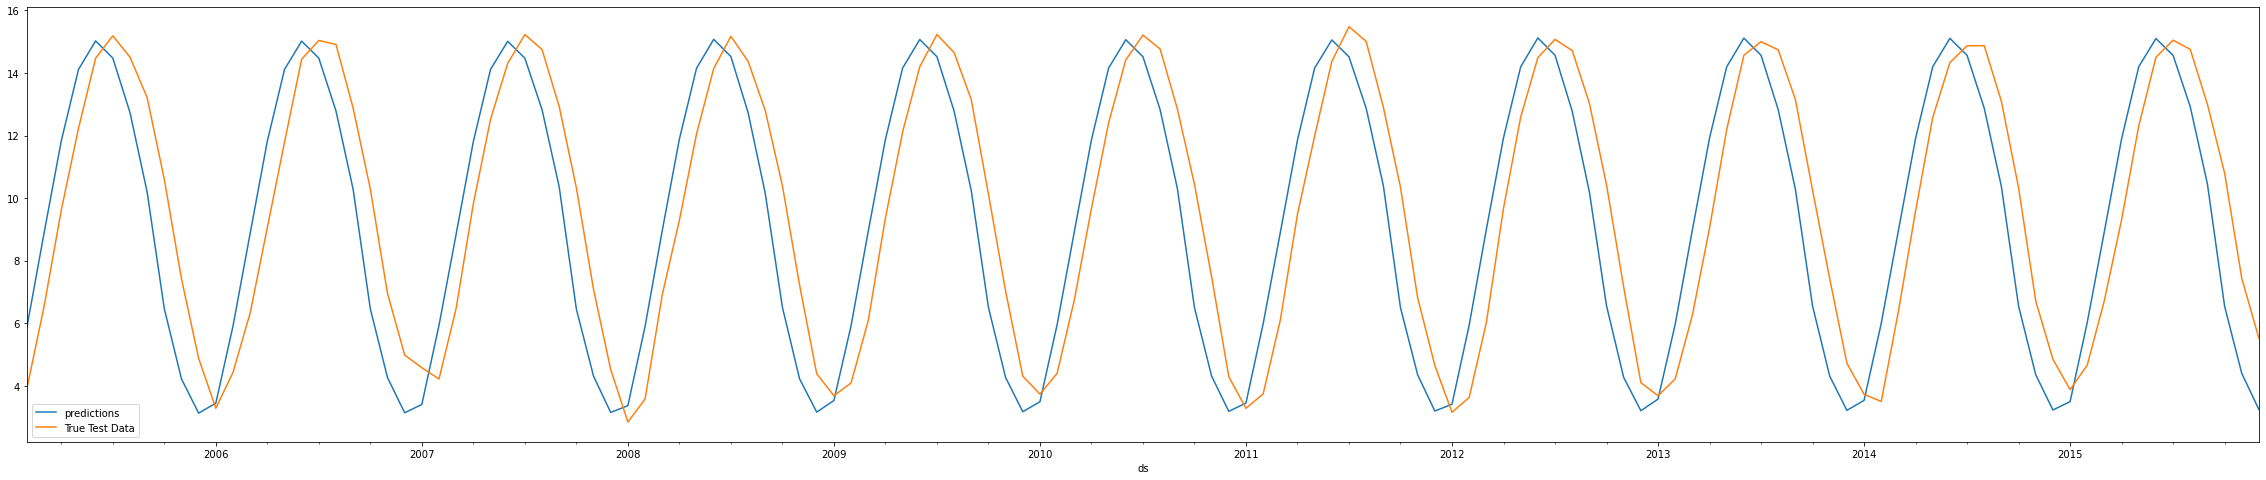

In [105]:
ax=forecast_values.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(40,8))
df_prophet_test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax)

In [106]:
df_merge = pd.DataFrame()
df_prophet_test = df_prophet_test.reset_index()
df_merge['true'] = df_prophet_test['y']
df_merge['predicted'] = forecast_values['yhat']
df_merge

true  predicted
0     3.920   5.880226
1     6.544   8.894414
2     9.618  11.833168
3    12.226  14.112044
4    14.476  15.027346
..      ...        ...
126  14.755  12.920931
127  12.999  10.449628
128  10.801   6.543147
129   7.433   4.397306
130   5.518   3.239758

[131 rows x 2 columns]

## Valutazione performances sul test set

In [107]:
y_true = df_merge['true'].values
y_pred = df_merge['predicted'].values
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
mape*100

# si ottiene un risultato migliore con il modello ARIMA in termini di MAPE

24.245989876591377

## Previsioni dal 2016 al 2026

In [108]:
model_prophet = Prophet()
model_prophet.fit(df_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
D:\Anaconda\envs\env_fisica\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [109]:
future = model_prophet.make_future_dataframe(periods=120, freq='M')

In [110]:
forecast = model_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

D:\Anaconda\envs\env_fisica\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

D:\Anaconda\envs\env_fisica\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



ds       yhat  yhat_lower  yhat_upper
3307 2025-07-31  15.015693   14.009713   16.092279
3308 2025-08-31  13.288761   12.234555   14.308305
3309 2025-09-30  10.748907    9.712151   11.815926
3310 2025-10-31   7.034858    5.952969    8.066081
3311 2025-11-30   4.778510    3.741953    5.821760

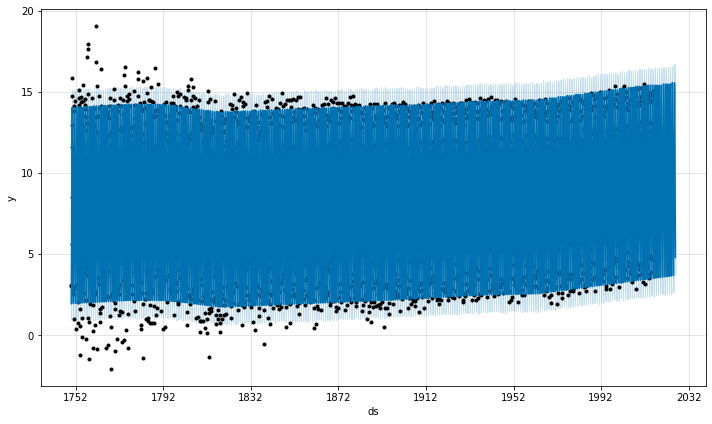

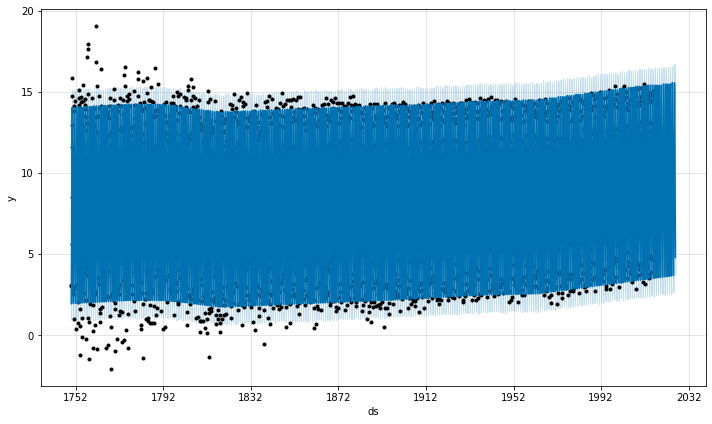

In [111]:
model_prophet.plot(forecast)

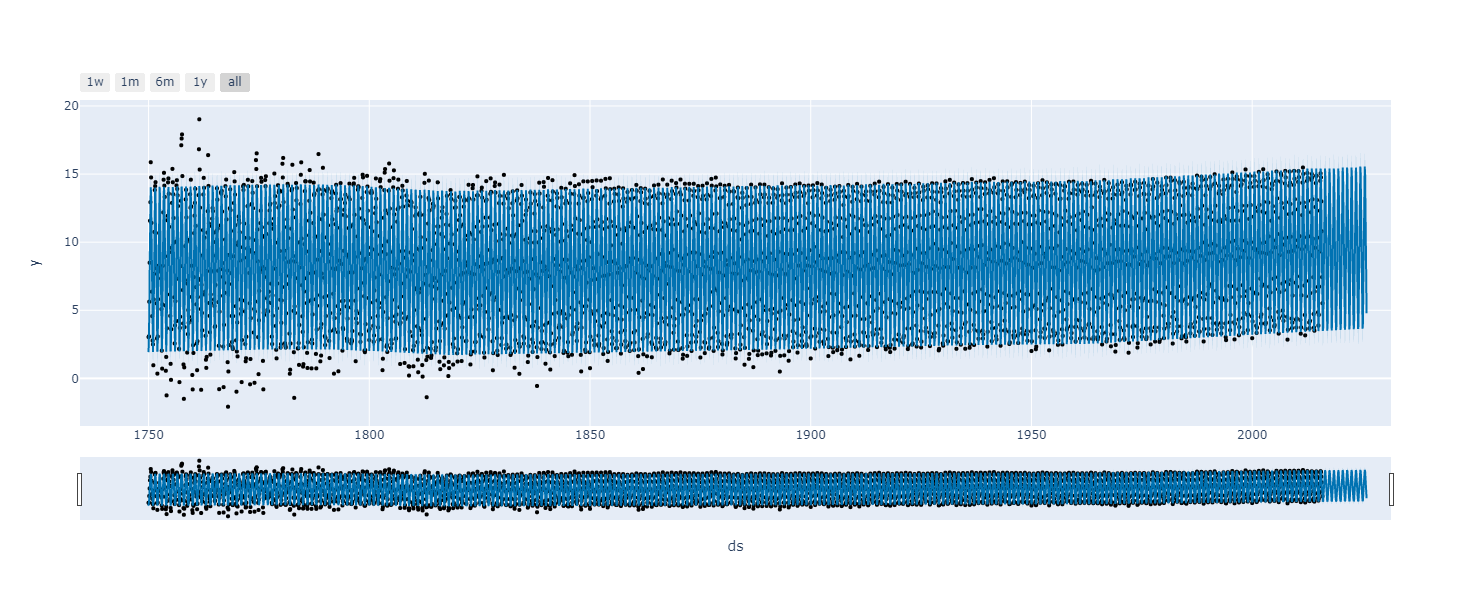

In [112]:
plot_plotly(model_prophet, forecast)

D:\Anaconda\envs\env_fisica\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



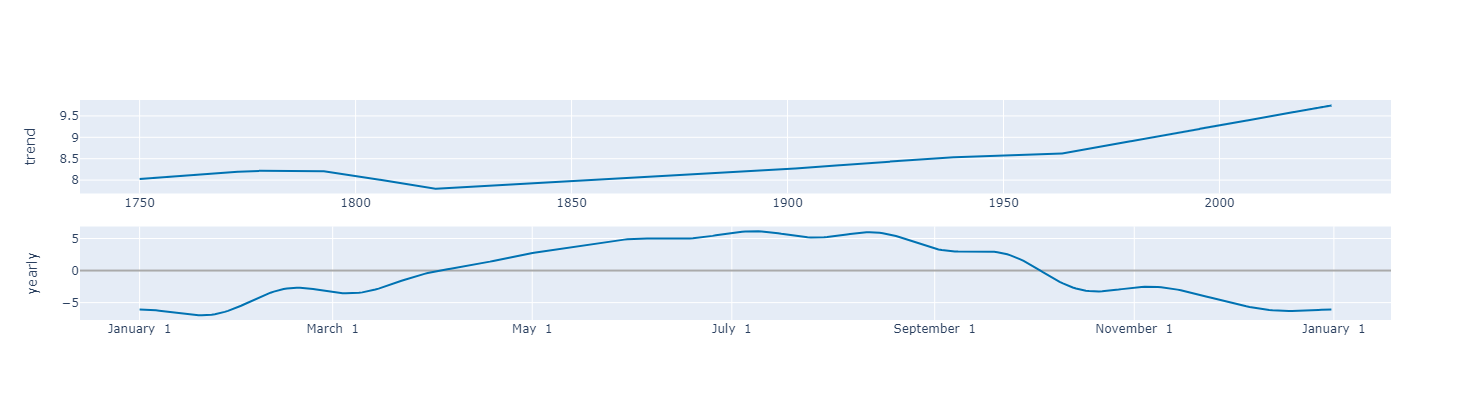

In [113]:
plot_components_plotly(model_prophet, forecast)

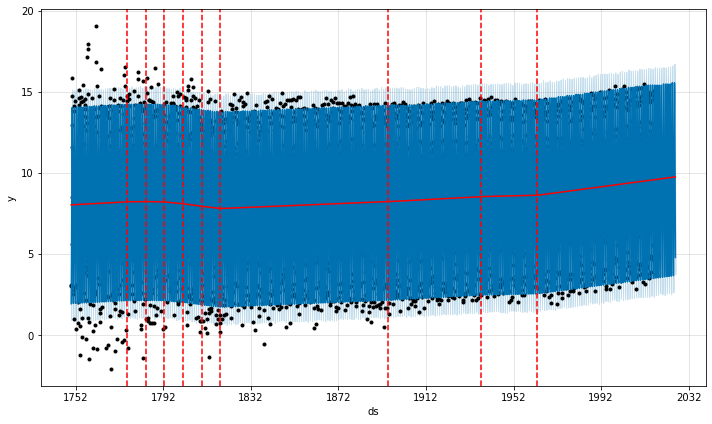

In [114]:
fig = model_prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model_prophet, forecast)